In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### **Data Preprocessing**


#### 1. Movie Data (arms)

In [ ]:
movie = pd.read_csv('ml-100k/u.item', header = None, sep = '|', encoding='latin-1')
movie.columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action',
                 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [ ]:
# drop unused features

movie_features = movie.drop(['video_release_date', 'IMDb_URL'], axis = 1)
movie_features.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


#### 3. Ratings Data (rewards)

In [ ]:
# read ratings data and drop timestamp column
data = pd.read_csv('ml-100k/u.data', sep ='\t', header=None, names = ['user_id', 'movie_id','rating', 'timestamp'])
data = data.drop(['timestamp'], axis = 1)

### **Filtering Data**

In [ ]:
# filter for top n movies

n = 30
top_movies_index = data.groupby('movie_id').count().sort_values('user_id', ascending = False).head(n).reset_index()['movie_id']
top_movies_features = movie_features[movie_features.movie_id.isin(top_movies_index)]
top_movies_features.to_numpy().shape

(30, 22)

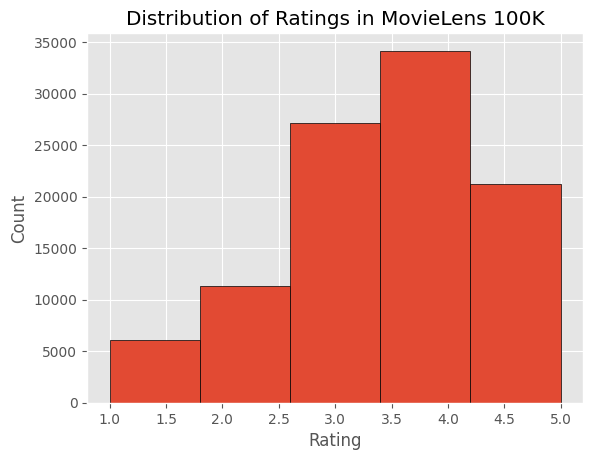

In [ ]:
#to show the distribution of ratings, can link to our threshold for giving reward = 1 if rating >= 4 and no reward if < 4 and to reiterate our problem statement of having low ratings.
plt.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

In [ ]:
# filter the ratings data
filtered_data = data[data['movie_id'].isin(top_movies_index)]
filtered_data['reward'] = np.where(filtered_data['rating'] < 4, 0, 1)
filtered_data = filtered_data.reset_index(drop = True)

<ipython-input-9-5477862bd61e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['reward'] = np.where(filtered_data['rating'] < 4, 0, 1)


In [ ]:
# filter the movie data
filtered_movie = movie_features[movie_features['movie_id'].isin(top_movies_index)]
filtered_movie = filtered_movie.reset_index(drop = True)

### **Preparing Data to Create Similarity Matrix**

In [ ]:
# collapse the genre columns to a single column

def changeToGenre(row):
    genre = ''
    if (row['unknown'] == 1):
      genre += 'unknown' + '|'
    if (row['Action'] == 1):
      genre += 'Action' + '|'
    if (row['Adventure'] == 1):
      genre += 'Adventure' + '|'
    if (row['Animation'] == 1):
      genre += 'Animation' + '|'
    if (row['Children\'s'] == 1):
      genre += 'Children\'s' + '|'
    if (row['Comedy'] == 1):
      genre += 'Comedy' + '|'
    if (row['Crime'] == 1):
      genre += 'Crime' + '|'
    if (row['Documentary'] == 1):
      genre += 'Documentary' + '|'
    if (row['Drama'] == 1):
      genre += 'Drama' + '|'
    if (row['Fantasy'] == 1):
      genre += 'Fantasy' + '|'
    if (row['Film-Noir'] == 1):
      genre += 'Film-Noir' + '|'
    if (row['Horror'] == 1):
      genre += 'Horror' + '|'
    if (row['Musical'] == 1):
      genre += 'Musical' + '|'
    if (row['Mystery'] == 1):
      genre += 'Mystery' + '|'
    if (row['Romance'] == 1):
      genre += 'Romance' + '|'
    if (row['Sci-Fi'] == 1):
      genre += 'Sci-Fi' + '|'
    if (row['Thriller'] == 1):
      genre += 'Thriller' + '|'
    if (row['War'] == 1):
      genre += 'War' + '|'
    if (row['Western'] == 1):
      genre += 'Western' + '|'
    if (len(genre) != 0):
      return genre[:len(genre)-1]
    else:
      return ''
    
# unknown | Action | Adventure | Animation |
#               Children's | Comedy | Crime | Documentary | Drama | Fantasy |
#               Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
#               Thriller | War | Western
filtered_movie['genres'] = filtered_movie.apply(lambda row: changeToGenre(row), axis = 1)
filtered_movie = filtered_movie[['movie_id','movie_title','release_date','genres']]
filtered_movie

,movie_id,movie_title,release_date,genres
0,1,Toy Story (1995),01-Jan-1995,Animation|Children's|Comedy
1,7,Twelve Monkeys (1995),01-Jan-1995,Drama|Sci-Fi
2,50,Star Wars (1977),01-Jan-1977,Action|Adventure|Romance|Sci-Fi|War
3,56,Pulp Fiction (1994),01-Jan-1994,Crime|Drama
4,69,Forrest Gump (1994),01-Jan-1994,Comedy|Romance|War
5,79,"Fugitive, The (1993)",01-Jan-1993,Action|Thriller
6,98,"Silence of the Lambs, The (1991)",01-Jan-1991,Drama|Thriller
7,100,Fargo (1996),14-Feb-1997,Crime|Drama|Thriller
8,117,"Rock, The (1996)",07-Jun-1996,Action|Adventure|Thriller
9,121,Independence Day (ID4) (1996),03-Jul-1996,Action|Sci-Fi|War


## Content-Based Recommendation 
adapted from https://www.kaggle.com/code/sachinsarkar/movielens-movie-recommendation-system/notebook

In [ ]:
#EDITED RECOMMENDER CODE

#changed data source name
#changed deprecated method
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
genres = vectorizer.fit_transform(filtered_movie.genres).toarray()
contents = pd.DataFrame(genres,columns=vectorizer.get_feature_names_out())
print('Shape of the content table :',contents.shape)
contents.head()

Shape of the content table : (30, 14)


,action,adventure,animation,children,comedy,crime,drama,fi,horror,mystery,romance,sci,thriller,war
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,0,0,1,0,0
2,1,1,0,0,0,0,0,1,0,0,1,1,0,1
3,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [ ]:
#changed contents to contents.values
from sklearn.neighbors import NearestNeighbors
nn_algo = NearestNeighbors(metric='cosine')
nn_algo.fit(contents.values)
contents.head()

,action,adventure,animation,children,comedy,crime,drama,fi,horror,mystery,romance,sci,thriller,war
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,0,0,1,0,0
2,1,1,0,0,0,0,0,1,0,0,1,1,0,1
3,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [ ]:
# pass in a list of movies_id history of a user that has reward = 1
# cannot recommend if history is empty ==> first round cannot exploit, must explore
class Recommender:
    def __init__(self, history):
        # change the history of movie id to index of that movie (since contents do not have movie_id column)
        index_list = filtered_movie.index[filtered_movie['movie_id'].isin(history)].tolist()
        self.hist = index_list

    # This method will originally recommend movies title based on history stored in self.hist list
    # changed n_recommend to 1 (can be overwritten)
    # changed to return movie ID instead of title
    def recommend(self,n_reccomend = 1):
        if len(self.hist) == 0:
            return print('No history found')
        history = np.array([list(contents.iloc[iloc]) for iloc in self.hist])
        distance,neighbors = nn_algo.kneighbors([np.average(history,axis=0)],n_neighbors=n_reccomend + len(self.hist))
        recommeds = [filtered_movie.iloc[i]['movie_id'] for i in neighbors[0] if i not in self.hist]
        return recommeds[:n_reccomend]

In [ ]:
#testing
recommender = Recommender([])
recommender.recommend()

No history found


In [ ]:
#id passed in is taken as row instead of movie_id
recommender = Recommender([79,98])
recommender.recommend(3)

[300, 100, 748]

In [ ]:
recommender = Recommender([1,7])
recommender.recommend(3)

[204, 258, 151]

In [ ]:
recommender = Recommender([1,1,1,7])
recommender.recommend(3)

[204, 258, 151]

### Initialising Variables

In [ ]:
#initializing arms, t and z values for bootstrap replay
arms = filtered_data['movie_id'].unique() # top 30 movie ids
z = len(filtered_data['movie_id'].unique()) # num of actions/arms
t = filtered_data.shape[0]
user = filtered_data['user_id'].unique()
# print(arms)
# print(z)
# print(t)
# print(len(user))

### Functions for Epsilon Decay Algorithm with n = 5


In [ ]:
# user_history data is the data of reward and movies of a user so far
# format: {0:[], 1:[]}
# history is the data of all the movies so far
def epsilon_decay_k_5(user_history, history):
    
    #calculate the epsilon of that user
    #1 / [(total play / num of arms) + 1] 
    num_watch = len(user_history.get(0)) + len(user_history.get(1))
    num_movies = z
    epsilon = 1 / (num_watch/num_movies + 1)

    # exploit, content based recommendation (recommend movies based on movies that the user like)
    # additional condition on top of epsilon value where there must be at least 1 movie that user like
    if random.random() > epsilon and len(user_history.get(1)) > 0: 

      # initializing the Recommender Object
      recommender = Recommender(user_history.get(1)) 

      # pass in the list of movies that user like to recommender
      return recommender.recommend()
          
    # explore, randomly select from all possible arms
    else: 
      #here is the exploration part
      #narrow down the exploration part by exploring only top n new/recent movies
      k = 5
      recentMovie = filtered_movie.copy()
      recentMovie['release_date'] = pd.to_datetime(recentMovie['release_date'])
      recentMovie = recentMovie.drop_duplicates(subset = "movie_id")
      recentMovie = recentMovie.sort_values(by='release_date', ascending=False)
      recentMovie = recentMovie.loc[:,"movie_id"].reset_index(drop=True).head(k)

      #we can also find movies similar to what user has rated good or
      #we can select n most popular movies and from there, select the movie most similar to the one he/she watched
      return np.random.choice(recentMovie, replace=False)

### Functions for Epsilon Decay Algorithm with n = 15


In [ ]:
# user_history data is the data of reward and movies of a user so far
# format: {0:[], 1:[]}
# history is the data of all the movies so far
def epsilon_decay_k_15(user_history, history):
    
    #calculate the epsilon of that user
    #1 / [(total play / num of arms) + 1] 
    num_watch = len(user_history.get(0)) + len(user_history.get(1))
    num_movies = z
    epsilon = 1 / (num_watch/num_movies + 1)

    # exploit, content based recommendation (recommend movies based on movies that the user like)
    # additional condition on top of epsilon value where there must be at least 1 movie that user like
    if random.random() > epsilon and len(user_history.get(1)) > 0: 

      # initializing the Recommender Object
      recommender = Recommender(user_history.get(1)) 

      # pass in the list of movies that user like to recommender
      return recommender.recommend()
          
    # explore, randomly select from all possible arms
    else: 
      #here is the exploration part
      #narrow down the exploration part by exploring only top n new/recent movies
      k = 15
      recentMovie = filtered_movie.copy()
      recentMovie['release_date'] = pd.to_datetime(recentMovie['release_date'])
      recentMovie = recentMovie.drop_duplicates(subset = "movie_id")
      recentMovie = recentMovie.sort_values(by='release_date', ascending=False)
      recentMovie = recentMovie.loc[:,"movie_id"].reset_index(drop=True).head(k)

      #we can also find movies similar to what user has rated good or
      #we can select n most popular movies and from there, select the movie most similar to the one he/she watched
      return np.random.choice(recentMovie, replace=False)

### Functions for Epsilon Decay Algorithm with n = 25


In [ ]:
# user_history data is the data of reward and movies of a user so far
# format: {0:[], 1:[]}
# history is the data of all the movies so far
def epsilon_decay_k_25(user_history, history):
    
    #calculate the epsilon of that user
    #1 / [(total play / num of arms) + 1] 
    num_watch = len(user_history.get(0)) + len(user_history.get(1))
    num_movies = z
    epsilon = 1 / (num_watch/num_movies + 1)

    # exploit, content based recommendation (recommend movies based on movies that the user like)
    # additional condition on top of epsilon value where there must be at least 1 movie that user like
    if random.random() > epsilon and len(user_history.get(1)) > 0: 

      # initializing the Recommender Object
      recommender = Recommender(user_history.get(1)) 

      # pass in the list of movies that user like to recommender
      return recommender.recommend()
          
    # explore, randomly select from all possible arms
    else: 
      #here is the exploration part
      #narrow down the exploration part by exploring only top n new/recent movies
      k = 25
      recentMovie = filtered_movie.copy()
      recentMovie['release_date'] = pd.to_datetime(recentMovie['release_date'])
      recentMovie = recentMovie.drop_duplicates(subset = "movie_id")
      recentMovie = recentMovie.sort_values(by='release_date', ascending=False)
      recentMovie = recentMovie.loc[:,"movie_id"].reset_index(drop=True).head(k)

      #we can also find movies similar to what user has rated good or
      #we can select n most popular movies and from there, select the movie most similar to the one he/she watched
      return np.random.choice(recentMovie, replace=False)

### Boostrap sample

In [ ]:
algorithms = [epsilon_decay_k_5,epsilon_decay_k_15,epsilon_decay_k_25]

evaluation = [] # dataframe for evaluation results

for f in algorithms:

    # bootstrap loop
    for b in range(1, 4): 

        # dictionary to store user history
        # key = user id, value = dictionary of (key = reward, value = movie ids)
        user_histories = {}

        # define 'history' container to store all knowledge learned for each movie id (arm)
        history_cols = ['arm', 'sum', 'mean', 'count']
        history = pd.DataFrame(data=None, columns=history_cols)
        history = history.astype({'arm': 'int32', 'sum': 'float', 'mean': 'float', 'count': 'float'})
        for j in range(0, len(arms)):
            history.loc[j] = [arms[j],0,0,0]

        step = 0
        for i in range(1, t*z+1):
        
            # sample data with replacement
            bootstrap_sample = resample(filtered_data, replace=True, n_samples=1)

            # access the dictionary using key = user_id and pass in the value to the algo
            # check whether user id exist, if not set default value, if yes then get the user history
            key = bootstrap_sample['user_id'].values[0]
            default_value= {0:[], 1:[]}
            user_history = user_histories.setdefault(key, default_value)
            
            # get recommendation from algorithm
            recommendation = f(user_history, history)

            # check if the recommendation matches the record at the step
            # if it does match, add to history so that the reward of this record can be revealed to the algorithm
            if recommendation == bootstrap_sample['movie_id'].values[0]:
                step += 1
                action = bootstrap_sample['movie_id'].values[0]
                reward = bootstrap_sample['reward'].values[0]

                #update data for evaluation graph
                update = {'bootstrap_sample':b, 'policy':f.__name__, 'log_step':i, 'time_step':step, 'chosen_arm':action, 'reward':reward}
                evaluation.append(update)

                #update history for movie
                history['count'] = np.where(history['arm']==action, history['count']+1, history['count'])
                history['sum'] = np.where(history['arm']==action, history['sum']+reward, history['sum'])
                history['mean'] = np.where(history['arm']==action, history['sum']/(history['count']+0.0), history['mean'])
            
                #update history for user
                user_history.get(reward).append(action)

            else:
                continue
        history['policy'] = f.__name__

# summarize all rounds, calculate the average
output_df = pd.DataFrame(evaluation)
output_df = output_df.sort_values(by=['policy', 'bootstrap_sample', 'time_step'])

### Plot Results

In [ ]:
output_df['cumulative_rewards'] = output_df.groupby(['policy','bootstrap_sample'], as_index=False)['reward'].cumsum()

In [ ]:
output_df.to_csv("replay_evaluation.csv",index=False)

(0.0, 9000.0)

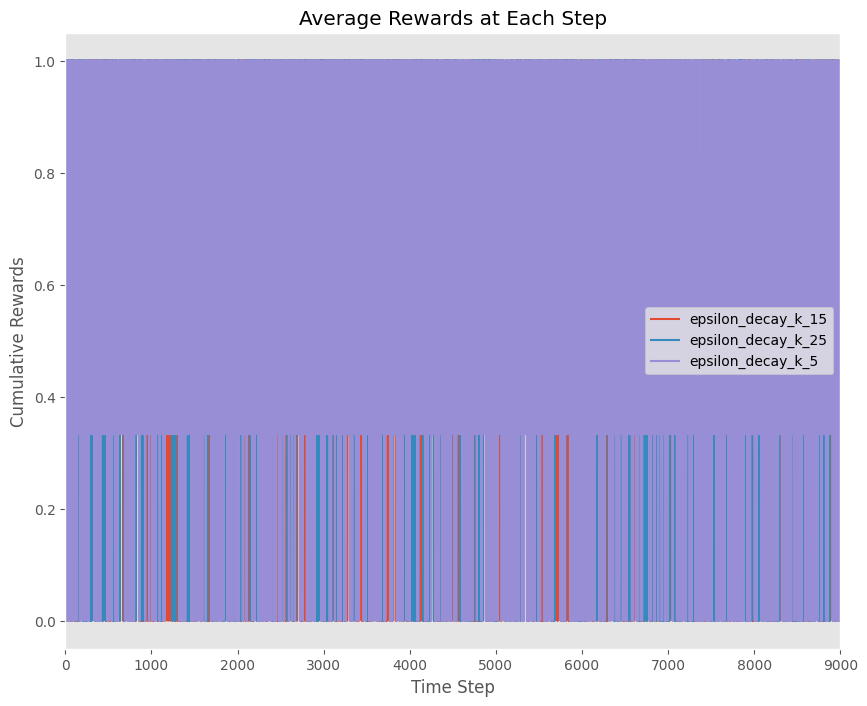

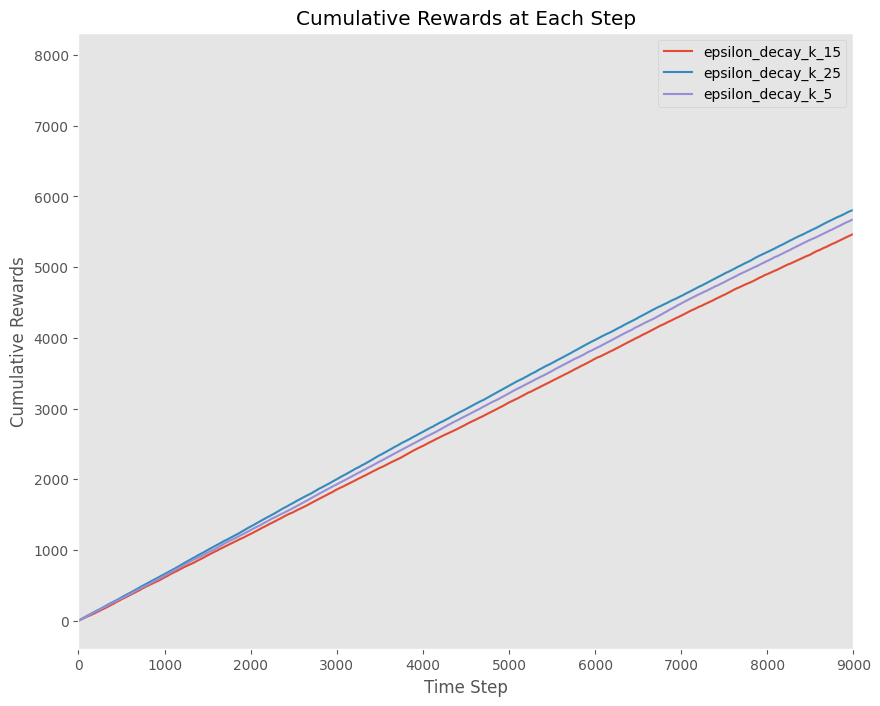

In [ ]:
output = ("replay_evaluation.csv")
all_results = pd.read_csv(output)
results_plot = all_results.groupby(['policy', 'time_step'])['reward'].mean()
results_plot = results_plot.reset_index()
results_plot['cumulative_rewards'] = results_plot.groupby(['policy'])['reward'].cumsum()
#results_plot = all_results.groupby(['policy','time_step'],as_index=False).aggregate({'reward':'mean', 'cumulative_rewards':'mean'})
#the plot looks like a square due to the size of the data
#results_plot.to_csv("resultsplot.csv",index=False)
plt.style.use('ggplot')

# plot for average rewards
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.grid(False)
for policy in results_plot['policy'].unique():
    ax.plot(results_plot[results_plot['policy']==policy]['time_step'],results_plot[results_plot['policy']==policy]['reward'], label=str(policy))
plt.legend()
plt.title('Average Rewards at Each Step')
plt.savefig('avg_rewards.png', dpi=300)
plt.xlabel("Time Step")
plt.ylabel("Cumulative Rewards")
#limit x axis to the lowest bootstrap resampling time_step
plt.xlim([0, 9000])

# plot for cumulative rewards
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.grid(False)
for policy in results_plot['policy'].unique(): 
    ax.plot(results_plot[results_plot['policy']==policy]['time_step'],results_plot[results_plot['policy']==policy]['cumulative_rewards'], label=str(policy))
plt.legend()
plt.title('Cumulative Rewards at Each Step')
plt.xlabel("Time Step")
plt.ylabel("Cumulative Rewards")
plt.savefig('cumulative_rewards.png', dpi=300)
#limit x axis to the lowest bootstrap resampling time_step
plt.xlim([0, 9000])